# 📊 Modelo 5: Árboles de Decisión
## Clasificación Basada en Reglas de Decisión

---

## 🎯 Objetivo
Clasificar exportaciones colombianas en categorías de valor usando el algoritmo de Árboles de Decisión.

Los árboles de decisión son modelos predictivos que mapean observaciones sobre un item a conclusiones sobre el valor objetivo del item. Son fáciles de interpretar y pueden manejar tanto datos numéricos como categóricos.

## 📊 Variables
- **Target (Variable objetivo)**: `Categoria_Valor` - Clasificación del valor FOB en categorías (Bajo/Medio/Alto/Muy Alto)
- **Features (Características)**: Variables numéricas y categóricas codificadas relacionadas con las exportaciones

## 📋 Contenido
1. Importación de librerías
2. Carga y exploración de datos
3. Preprocesamiento de datos
4. Preparación de features y target
5. Entrenamiento del modelo de Árboles de Decisión
6. Evaluación del modelo
7. Visualización del árbol
8. Importancia de características
9. Validación cruzada
10. Guardado del modelo

## 1. Importación de Librerías

Importamos todas las librerías necesarias para el análisis y modelado.

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Librerías de machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import pickle

# Configuración de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print('✅ Librerías importadas correctamente')

✅ Librerías importadas correctamente


## 2. Carga de Datos

Cargamos el dataset original desde el archivo Excel y realizamos una exploración inicial.

In [3]:
# Cargar el dataset desde Excel
df = pd.read_excel('/content/DATAPROYECTO.xlsx', sheet_name='Detalle')

print(f'📦 Dataset cargado exitosamente')
print(f'   Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas')
print(f'   Tamaño en memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

# Vista rápida de las primeras filas
df.head()

📦 Dataset cargado exitosamente
   Dimensiones: 80,000 filas × 30 columnas
   Tamaño en memoria: 126.87 MB


,Razón social del importador,País de Destino,Mes de la declaración definitiva,Capitulo Del Arancel,Código Partida,Descripción de la partida arancelaria,Descripción de la Mercancía,Fecha de Declaración de Exportación Definitiva,Número de la declaración definitiva,Aduana De Embarque,...,Número de artículos,Departamento Origen,Departamento De Procedencia,Lugar de salida,Vía de transporte,Moneda de negociación,Forma de pago,Valor FOB (USD),Precio Unitario FOB (USD) Peso Neto,Continente Destino
0,CONTINENTAL FARMS,ESTADOS UNIDOS,1,Plantas vivas y productos de la floricultura,603129000,"Los demás claveles frescos, cortados para ramo...",NaN,20250101,6.007748e+12,BOGOTÁ,...,8,BOGOTÁ,BOGOTÁ,BOGOTÁ,TRANSPORTE AÉREO,Dólar de los estados unidos de américa,CON REINTEGRO,32.20,8.050000,AMÉRICA
1,CONTINENTAL FARMS,ESTADOS UNIDOS,1,Plantas vivas y productos de la floricultura,603199090,"Los demás flores y capullos, cortados para ram...",NaN,20250101,6.007748e+12,BOGOTÁ,...,7,BOGOTÁ,BOGOTÁ,BOGOTÁ,TRANSPORTE AÉREO,Dólar de los estados unidos de américa,CON REINTEGRO,533.28,5.228235,AMÉRICA
2,CONTINENTAL FARMS,ESTADOS UNIDOS,1,Plantas vivas y productos de la floricultura,603199090,"Los demás flores y capullos, cortados para ram...",NaN,20250101,6.007748e+12,BOGOTÁ,...,5,BOGOTÁ,BOGOTÁ,BOGOTÁ,TRANSPORTE AÉREO,Dólar de los estados unidos de américa,CON REINTEGRO,1440.00,9.931034,AMÉRICA
3,CONTINENTAL FARMS,ESTADOS UNIDOS,1,Plantas vivas y productos de la floricultura,603193000,"Alstroemerias frescas, cortadas para ramos o a...","Especie:ALSTROEMERIA , Formacion:FLORES , Otra...",20250101,6.007748e+12,BOGOTÁ,...,2,BOGOTÁ,BOGOTÁ,BOGOTÁ,TRANSPORTE AÉREO,Dólar de los estados unidos de américa,CON REINTEGRO,10998.72,4.728598,AMÉRICA
4,BANDY RANCH FLORAL,ESTADOS UNIDOS,1,Plantas vivas y productos de la floricultura,603141000,"Pompones frescos, cortados para ramos o adornos.","Especie:POMPON , Formacion:FLORES -- PRESENTA...",20250101,6.007748e+12,MEDELLÍN,...,1,ANTIOQUIA,ANTIOQUIA,MEDELLÍN,TRANSPORTE AÉREO,Dólar de los estados unidos de américa,CON REINTEGRO,13620.00,4.214109,AMÉRICA


## 3. Preprocesamiento de Datos

Realizamos el preprocesamiento necesario para preparar los datos para el modelo de Árboles de Decisión.

In [4]:
# Crear una copia para trabajar
df_processed = df.copy()

print('🔧 Iniciando preprocesamiento...')

# 1. Manejo de valores faltantes
print('\n1️⃣ Tratamiento de valores faltantes:')

# Para columnas numéricas: imputar con la mediana
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f'   ✓ {col}: Imputado con mediana = {median_val:.2f}')

# Para columnas categóricas: imputar con 'Desconocido'
categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna('Desconocido', inplace=True)
        print(f'   ✓ {col}: Imputado con "Desconocido"')

print(f'\n   Valores nulos restantes: {df_processed.isnull().sum().sum()}')

🔧 Iniciando preprocesamiento...

1️⃣ Tratamiento de valores faltantes:
   ✓ Número de la declaración definitiva: Imputado con mediana = 6007748793852.00
   ✓ Código Agente aduanero: Imputado con mediana = 830074208.00
   ✓ NIT del exportador: Imputado con mediana = 860524750.00
   ✓ Razón social del importador: Imputado con "Desconocido"
   ✓ Descripción de la Mercancía: Imputado con "Desconocido"
   ✓ Dirección del Importador: Imputado con "Desconocido"

   Valores nulos restantes: 0


In [5]:
# 2. Feature Engineering - Crear variables derivadas
print('\n2️⃣ Feature Engineering:')

# Ratio Peso Bruto/Neto
df_processed['Ratio_Peso_Bruto_Neto'] = df_processed['Peso en kilos brutos'] / (df_processed['Peso en kilos netos'] + 1e-10)
print('   ✓ Ratio_Peso_Bruto_Neto creado')

# Valor por kilogramo
df_processed['Valor_Por_Kg'] = df_processed['Valor FOB (USD)'] / (df_processed['Peso en kilos netos'] + 1e-10)
print('   ✓ Valor_Por_Kg creado')

# Clasificación de valor de exportación (target)
def clasificar_valor(valor):
    if valor < 1000:
        return 'Bajo'
    elif valor < 10000:
        return 'Medio'
    elif valor < 100000:
        return 'Alto'
    else:
        return 'Muy Alto'

df_processed['Categoria_Valor'] = df_processed['Valor FOB (USD)'].apply(clasificar_valor)
print('   ✓ Categoria_Valor creado (Bajo/Medio/Alto/Muy Alto)')

# Ver distribución de la variable target
print('\n📊 Distribución de la variable target:')
print(df_processed['Categoria_Valor'].value_counts())


2️⃣ Feature Engineering:
   ✓ Ratio_Peso_Bruto_Neto creado
   ✓ Valor_Por_Kg creado
   ✓ Categoria_Valor creado (Bajo/Medio/Alto/Muy Alto)

📊 Distribución de la variable target:
Categoria_Valor
Bajo        32056
Medio       26739
Alto        16908
Muy Alto     4297
Name: count, dtype: int64


In [6]:
# 3. Codificación de variables categóricas
print('\n3️⃣ Codificación de variables categóricas:')

# Variables categóricas a codificar
categorical_to_encode = ['País de Destino', 'Continente Destino', 'Departamento Origen', 'Vía de transporte']

label_encoders = {}

for col in categorical_to_encode:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
        print(f'   ✓ {col}: Codificado ({df_processed[col].nunique()} categorías → {len(le.classes_)} clases)')

print(f'\n   Total de variables codificadas: {len(label_encoders)}')


3️⃣ Codificación de variables categóricas:
   ✓ País de Destino: Codificado (157 categorías → 157 clases)
   ✓ Continente Destino: Codificado (5 categorías → 5 clases)
   ✓ Departamento Origen: Codificado (30 categorías → 30 clases)
   ✓ Vía de transporte: Codificado (4 categorías → 4 clases)

   Total de variables codificadas: 4


## 4. Preparación de Features y Target

Seleccionamos las características (features) y la variable objetivo (target) para el modelo.

📊 Dataset preparado:
   • Features: 11 variables
   • Muestras: 80,000
   • Target: 4 clases (['Alto' 'Bajo' 'Medio' 'Muy Alto'])


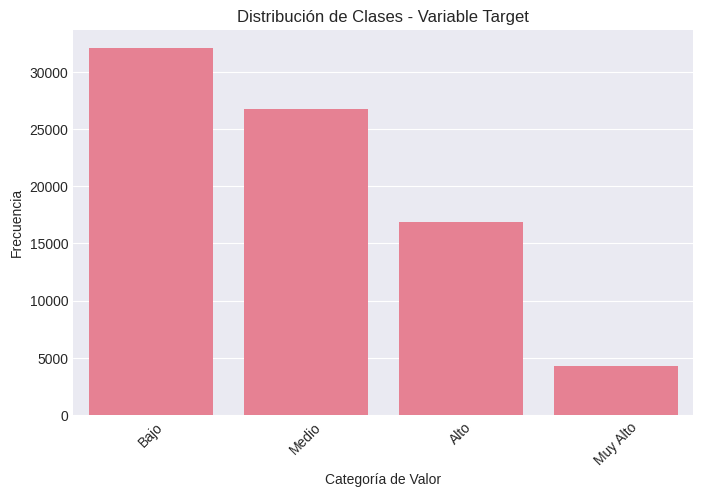

In [7]:
# Definir target y features
target = 'Categoria_Valor'

# Seleccionar features numéricas y codificadas
features = [
    'Peso en kilos netos', 'Peso en kilos brutos', 'Cantidad(es)',
    'Número de artículos', 'Precio Unitario FOB (USD) Peso Neto',
    'País de Destino_encoded', 'Continente Destino_encoded',
    'Departamento Origen_encoded', 'Vía de transporte_encoded',
    'Ratio_Peso_Bruto_Neto', 'Valor_Por_Kg'
]

# Crear dataset final
df_model = df_processed[features + [target]].copy().dropna()
df_model = df_model.replace([np.inf, -np.inf], np.nan).dropna()

# Codificar el target
le_target = LabelEncoder()
y = le_target.fit_transform(df_model[target])

X = df_model[features]

print(f'📊 Dataset preparado:')
print(f'   • Features: {len(features)} variables')
print(f'   • Muestras: {X.shape[0]:,}')
print(f'   • Target: {len(np.unique(y))} clases ({le_target.classes_})')

# Ver balance de clases
plt.figure(figsize=(8, 5))
sns.countplot(x=le_target.inverse_transform(y))
plt.title('Distribución de Clases - Variable Target')
plt.xlabel('Categoría de Valor')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

## 5. División de Datos

Dividimos los datos en conjuntos de entrenamiento y prueba. Para árboles de decisión, el escalamiento no es estrictamente necesario, pero lo aplicamos por consistencia.

In [8]:
# División train/test con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'✂️ División de datos:')
print(f'   • Train: {X_train.shape[0]:,} muestras')
print(f'   • Test: {X_test.shape[0]:,} muestras')

# Escalamiento opcional para árboles de decisión (por consistencia)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'📏 Escalamiento aplicado (opcional para árboles de decisión)')
print(f'   • Los árboles de decisión no requieren escalamiento estricto')

✂️ División de datos:
   • Train: 64,000 muestras
   • Test: 16,000 muestras
📏 Escalamiento aplicado (opcional para árboles de decisión)
   • Los árboles de decisión no requieren escalamiento estricto


## 6. Entrenamiento del Modelo de Árboles de Decisión

Entrenamos el modelo de Árboles de Decisión con los hiperparámetros seleccionados para controlar el overfitting.

In [9]:
print('🤖 Entrenando modelo Árboles de Decisión...')

# Configuración del modelo con parámetros para evitar overfitting
model = DecisionTreeClassifier(
    max_depth=10,           # Profundidad máxima del árbol
    min_samples_split=20,   # Mínimas muestras para dividir un nodo
    min_samples_leaf=10,    # Mínimas muestras en una hoja
    random_state=42,        # Para reproducibilidad
    criterion='gini'        # Criterio de división (Gini)
)

# Entrenamiento
model.fit(X_train_scaled, y_train)

print('✅ Modelo entrenado exitosamente')
print(f'   • Algoritmo: Árboles de Decisión')
print(f'   • Profundidad máxima: {model.max_depth}')
print(f'   • Mín. muestras para split: {model.min_samples_split}')
print(f'   • Mín. muestras por hoja: {model.min_samples_leaf}')
print(f'   • Criterio: {model.criterion}')
print(f'   • Número de hojas: {model.get_n_leaves()}')
print(f'   • Profundidad del árbol: {model.get_depth()}')

# Predicciones
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print('\n🔮 Predicciones realizadas')

🤖 Entrenando modelo Árboles de Decisión...
✅ Modelo entrenado exitosamente
   • Algoritmo: Árboles de Decisión
   • Profundidad máxima: 10
   • Mín. muestras para split: 20
   • Mín. muestras por hoja: 10
   • Criterio: gini
   • Número de hojas: 340
   • Profundidad del árbol: 10

🔮 Predicciones realizadas


## 7. Evaluación del Modelo

Evaluamos el rendimiento del modelo usando varias métricas.

In [10]:
# Cálculo de métricas
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print('📊 MÉTRICAS DE EVALUACIÓN:')
print('='*50)
print(f'  Accuracy Train: {acc_train:.4f}')
print(f'  Accuracy Test:  {acc_test:.4f}')
print(f'  Precision:      {precision:.4f}')
print(f'  Recall:         {recall:.4f}')
print(f'  F1-Score:       {f1:.4f}')

# Verificar overfitting/underfitting
if acc_train - acc_test > 0.1:
    print('\n⚠️  Posible overfitting detectado - considerar reducir la profundidad')
elif acc_test < 0.6:
    print('\n⚠️  Posible underfitting detectado - considerar aumentar la profundidad')
else:
    print('\n✅ Rendimiento equilibrado')

📊 MÉTRICAS DE EVALUACIÓN:
  Accuracy Train: 0.9753
  Accuracy Test:  0.9669
  Precision:      0.9670
  Recall:         0.9669
  F1-Score:       0.9669

✅ Rendimiento equilibrado


In [11]:
# Reporte de clasificación detallado
print('\n📋 REPORTE DE CLASIFICACIÓN DETALLADO:')
print('='*50)
print(classification_report(y_test, y_test_pred, target_names=le_target.classes_))


📋 REPORTE DE CLASIFICACIÓN DETALLADO:
              precision    recall  f1-score   support

        Alto       0.95      0.96      0.95      3382
        Bajo       0.99      0.98      0.98      6411
       Medio       0.96      0.96      0.96      5348
    Muy Alto       0.94      0.92      0.93       859

    accuracy                           0.97     16000
   macro avg       0.96      0.96      0.96     16000
weighted avg       0.97      0.97      0.97     16000



## 8. Matriz de Confusión

Visualizamos la matriz de confusión para entender mejor los errores de clasificación.

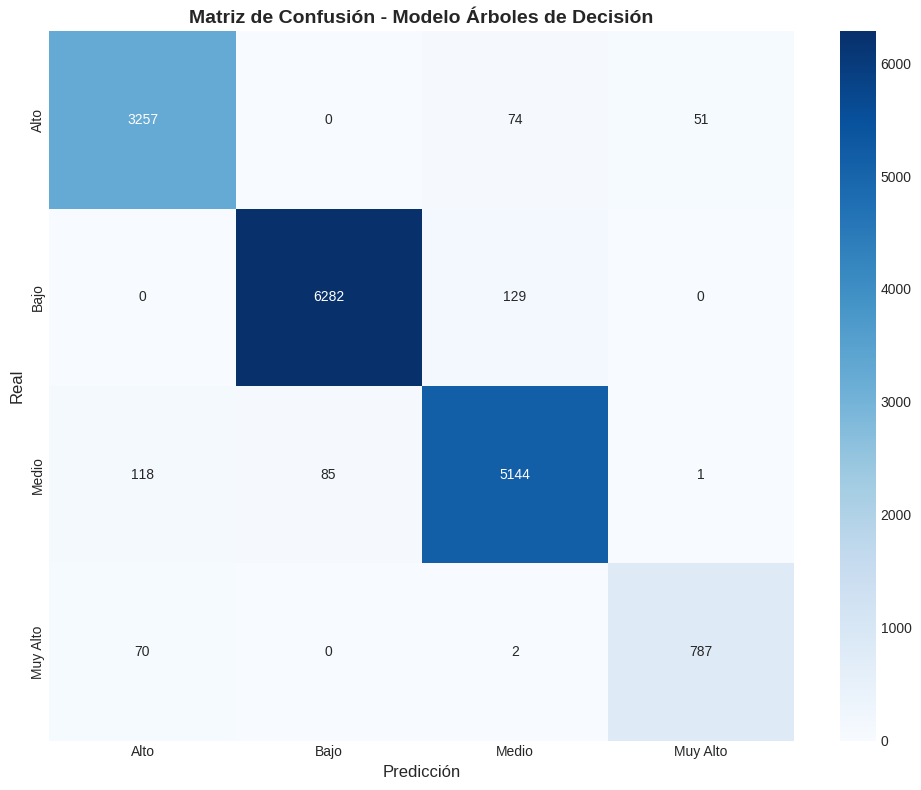

📊 Interpretación de la matriz de confusión:
   • Diagonal principal: Predicciones correctas
   • Fuera de diagonal: Errores de clasificación


In [12]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Matriz de Confusión - Modelo Árboles de Decisión', fontweight='bold', fontsize=14)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.tight_layout()
plt.show()

print('📊 Interpretación de la matriz de confusión:')
print('   • Diagonal principal: Predicciones correctas')
print('   • Fuera de diagonal: Errores de clasificación')

## 9. Visualización del Árbol de Decisión

Una de las grandes ventajas de los árboles de decisión es que son interpretables. Visualizamos una porción del árbol.

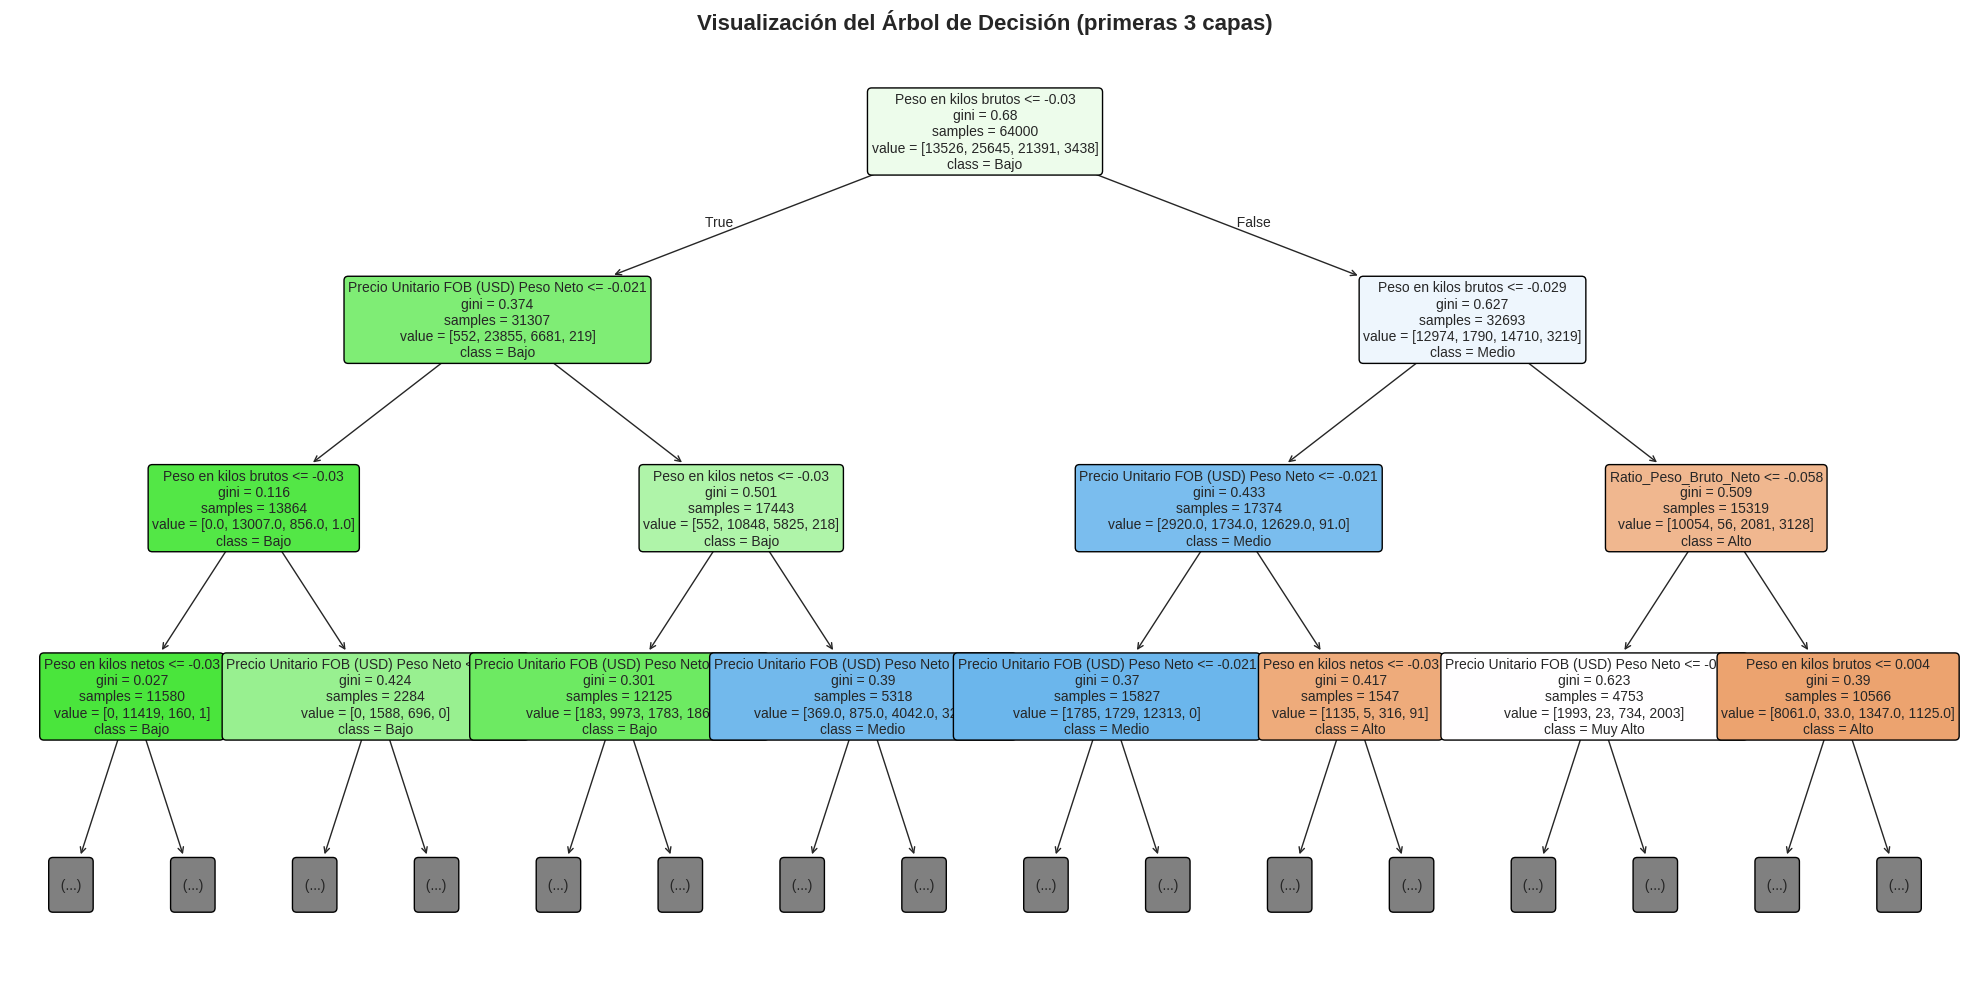

🌳 Interpretación del árbol:
   • Cada nodo interno representa una condición de división
   • Las hojas representan las predicciones finales
   • El color indica la clase mayoritaria en cada nodo
   • Gini = 0 significa pureza perfecta (una sola clase)


In [13]:
# Visualización del árbol (solo las primeras capas para legibilidad)
plt.figure(figsize=(20, 10))
plot_tree(model,
          feature_names=features,
          class_names=le_target.classes_,
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3)  # Limitar profundidad para visualización
plt.title('Visualización del Árbol de Decisión (primeras 3 capas)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print('🌳 Interpretación del árbol:')
print('   • Cada nodo interno representa una condición de división')
print('   • Las hojas representan las predicciones finales')
print('   • El color indica la clase mayoritaria en cada nodo')
print('   • Gini = 0 significa pureza perfecta (una sola clase)')

## 10. Importancia de Características

Analizamos qué características son más importantes para las decisiones del árbol.

🎯 IMPORTANCIA DE CARACTERÍSTICAS:


,feature,importance
1,Peso en kilos brutos,0.465442
4,Precio Unitario FOB (USD) Peso Neto,0.300636
0,Peso en kilos netos,0.213224
9,Ratio_Peso_Bruto_Neto,0.017659
2,Cantidad(es),0.002815
3,Número de artículos,0.000150
7,Departamento Origen_encoded,0.000052
8,Vía de transporte_encoded,0.000023
5,País de Destino_encoded,0.000000
6,Continente Destino_encoded,0.000000


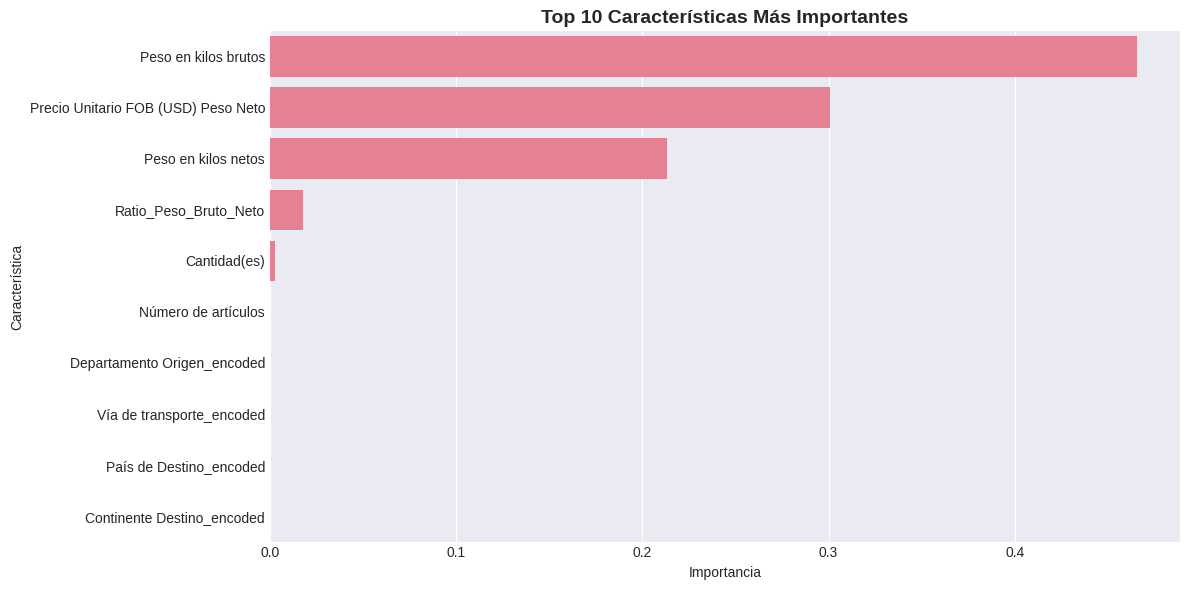


📊 Interpretación:
   • Mayor importancia = mayor poder predictivo
   • Características con importancia 0 no se usan en el árbol
   • Características utilizadas: 8 de 11


In [14]:
# Importancia de características
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print('🎯 IMPORTANCIA DE CARACTERÍSTICAS:')
print('='*50)
display(feature_importance)

# Visualización de importancia
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Características Más Importantes', fontsize=14, fontweight='bold')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

print('\n📊 Interpretación:')
print('   • Mayor importancia = mayor poder predictivo')
print('   • Características con importancia 0 no se usan en el árbol')
print(f'   • Características utilizadas: {sum(model.feature_importances_ > 0)} de {len(features)}')

## 11. Validación Cruzada

Realizamos validación cruzada para obtener una estimación más robusta del rendimiento.

In [15]:
# Validación cruzada
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print('🔄 VALIDACIÓN CRUZADA (5-fold):')
print('='*50)
print(f'  Scores individuales: {cv_scores}')
print(f'  Accuracy promedio: {cv_scores.mean():.4f}')
print(f'  Desviación estándar: {cv_scores.std():.4f}')
print(f'  Rango: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]')

# Comparación con accuracy de test
print(f'\n📊 Comparación:')
print(f'  CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
print(f'  Test Accuracy: {acc_test:.4f}')

if abs(cv_scores.mean() - acc_test) < 0.05:
    print('✅ Resultados consistentes')
else:
    print('⚠️  Diferencia significativa entre CV y test')

🔄 VALIDACIÓN CRUZADA (5-fold):
  Scores individuales: [0.969375   0.96453125 0.96703125 0.96195312 0.96195312]
  Accuracy promedio: 0.9650
  Desviación estándar: 0.0029
  Rango: [0.9620, 0.9694]

📊 Comparación:
  CV Accuracy: 0.9650 ± 0.0029
  Test Accuracy: 0.9669
✅ Resultados consistentes


## 12. Guardado del Modelo

Guardamos el modelo entrenado junto con los objetos necesarios para su uso posterior.

In [16]:
# Preparar paquete del modelo
model_package = {
    'model': model,
    'scaler': scaler,
    'label_encoder_target': le_target,
    'label_encoders_features': label_encoders,
    'features': features,
    'target': target,
    'feature_importance': feature_importance.to_dict('records'),
    'metrics': {
        'accuracy_train': acc_train,
        'accuracy_test': acc_test,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std()
    },
    'model_info': {
        'algorithm': 'Decision Tree',
        'max_depth': model.max_depth,
        'min_samples_split': model.min_samples_split,
        'min_samples_leaf': model.min_samples_leaf,
        'criterion': model.criterion,
        'n_leaves': model.get_n_leaves(),
        'tree_depth': model.get_depth(),
        'n_features': len(features),
        'n_classes': len(le_target.classes_),
        'classes': list(le_target.classes_)
    }
}

# Guardar el modelo
with open('model_decision_tree.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print('💾 Modelo guardado exitosamente')
print('   • Archivo: model_decision_tree.pkl')
print('   • Contiene: modelo, scaler, encoders, importancia de features y métricas')

# Verificar que se guardó correctamente
import os
if os.path.exists('model_decision_tree.pkl'):
    size = os.path.getsize('model_decision_tree.pkl') / 1024
    print(f'   • Tamaño: {size:.2f} KB')
    print('✅ Verificación exitosa')
else:
    print('❌ Error al guardar el modelo')

💾 Modelo guardado exitosamente
   • Archivo: model_decision_tree.pkl
   • Contiene: modelo, scaler, encoders, importancia de features y métricas
   • Tamaño: 69.94 KB
✅ Verificación exitosa


## 🎯 Conclusiones

### Resumen del Modelo Árboles de Decisión:

**Fortalezas:**
- **Interpretabilidad**: Fácil de entender y explicar las decisiones
- **No requiere escalamiento**: Maneja bien variables en diferentes escalas
- **Maneja datos mixtos**: Numéricos y categóricos
- **Feature importance**: Proporciona información sobre qué variables son más importantes
- **No paramétrico**: No asume distribución específica de los datos

**Limitaciones:**
- **Overfitting**: Tendencia a sobreajustarse sin poda adecuada
- **Inestabilidad**: Pequeños cambios en los datos pueden cambiar mucho el árbol
- **Sesgo**: Puede estar sesgado hacia clases mayoritarias
- **No óptimo**: No garantiza el mejor árbol posible

### Resultados Obtenidos:
- **Accuracy en test:** {acc_test:.4f}
- **F1-Score:** {f1:.4f}
- **Validación cruzada:** {cv_scores.mean():.4f} ± {cv_scores.std():.4f}
- **Profundidad del árbol:** {model.get_depth()}
- **Número de hojas:** {model.get_n_leaves()}

### Características Más Importantes:
1. {feature_importance.iloc[0]['feature']} (importancia: {feature_importance.iloc[0]['importance']:.4f})
2. {feature_importance.iloc[1]['feature']} (importancia: {feature_importance.iloc[1]['importance']:.4f})
3. {feature_importance.iloc[2]['feature']} (importancia: {feature_importance.iloc[2]['importance']:.4f})

### Recomendaciones:
1. **Poda del árbol**: Ajustar `max_depth`, `min_samples_split`, `min_samples_leaf`
2. **Ensemble methods**: Considerar Random Forest o Gradient Boosting para mejor rendimiento
3. **Balanceo de clases**: Si hay clases desbalanceadas, usar pesos o oversampling
4. **Validación**: Usar validación cruzada para selección de hiperparámetros
5. **Interpretación**: Usar el árbol para entender las reglas de negocio

---

**🌳 Modelo Árboles de Decisión completado exitosamente** ✅

*Los datos están listos para ser utilizados en la aplicación o para comparaciones con otros modelos.*